# Thermal food processing surrogate
Part A: Varying number of augmented dimensions.

In [ ]:
import sys; sys.path.append('../../..')   # Allow relative imports from the parent folder

import numpy as np

from matplotlib import pyplot as plt 

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
from jaxtyping import Array

import optax

import equinox as eqx

from dynax import training
from dynax import evaluation
from dynax.function_models import LyapunovNN, OnsagerNetPotential, FICNN, \
                                  ConstantSkewSymmetricMatrix, \
                                  ConstantMatrix, ConstantSPDMatrix, \
                                  MLP
from dynax.integration_models import ODESolver
from dynax.derivative_models import BaseModel, ISPHS
from dynax.losses import mse
from dynax.sphnn_tools import is_zero_gas_guarantee_valid
from dynax.data_handling import Normalizer, NormalizationWrapper

from pathlib import Path
import json

from functools import partial

from util import colors
from util.model_meta import model_style, model_names

ACTIVATIONS = dict(
    softplus = jax.nn.softplus,
    tanh = jax.nn.tanh,
    relu = jax.nn.relu,
)

INITIALIZERS = dict(
    he_uniform = jax.nn.initializers.he_uniform(),
    glorot_uniform = jax.nn.initializers.glorot_uniform(),
    zeros = jax.nn.initializers.zeros,
)

### Matplotlib Settings 
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors.set_custom_cycle()

PLOT_DPI = 200

## Model and training definitions

In [2]:
def define_sPHNN_model(model_hyperparams: dict,
                       num_aug: int,
                       *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'], # Hardcoded old version: jnn.initializers.glorot_uniform(),
                  b_initializer=model_hyperparams['bias_initialization'],   # Hardcoded old version: jnn.initializers.normal(),
                  key=h_key)
    H = LyapunovNN(ficnn, minimum=jnp.zeros(state_size))
    sphnn_ = ISPHS(H, J, R, g)
    sphnn_ode = ODESolver(sphnn_, augmentation=num_aug, augmentation_learnable=False)

    return sphnn_ode

def define_sPHNN_LM_model(model_hyperparams: dict,
                          num_aug: int,
                          *, key):
    j_key, r_key, g_key, h_key, minimum_key = jr.split(key, 5)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix(
        (state_size, input_size), initialize=jnn.initializers.zeros, key=g_key
    )

    ficnn = FICNN(
        state_size,
        "scalar",
        width=model_hyperparams["ficnn_width"],
        depth=model_hyperparams["ficnn_depth"],
        activation=jnn.softplus,
        w_initializer=model_hyperparams["weight_initialization"],
        b_initializer=model_hyperparams["bias_initialization"],
        key=h_key,
    )
    _H = LyapunovNN(ficnn)
    initial_minimum = jax.nn.initializers.normal(
        model_hyperparams["minimum_initializer_std"]
    )(minimum_key, _H.minimum.shape)
    H = eqx.tree_at(lambda x: x.minimum, _H, initial_minimum)
    assert H.minimum_learnable, "Minimum is not learnable for sPHNN_LM"
    sphnn_ = ISPHS(H, J, R, g)
    sphnn_ode = ODESolver(sphnn_, augmentation=num_aug, augmentation_learnable=False)

    return sphnn_ode

def define_PHNN_model(model_hyperparams: dict,
                      num_aug: int,
                      *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = MLP(in_size=state_size, out_size='scalar', 
            width_size=model_hyperparams['mlp_width'],
            depth=model_hyperparams['mlp_depth'],
            weight_initializer=model_hyperparams['weight_initialization'],
            bias_initializer=model_hyperparams['bias_initialization'],  
            activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
            key=h_key)
    phnn_ = ISPHS(H, J, R, g)
    phnn_ode_ = ODESolver(phnn_, augmentation=num_aug, augmentation_learnable=True) # 1 Parameters

    return phnn_ode_

def define_NODE_model(model_hyperparams: dict,
                      num_aug: int,
                      *, key):
    
    state_size, input_size = 2 + num_aug, 1

    mlp = MLP(state_size+input_size, state_size, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
              key=key)
    div_model = BaseModel(mlp, state_size, input_size)
    node = ODESolver(div_model, augmentation=num_aug, augmentation_learnable=True,
                     max_steps=8192,    # Hopefully all nodes can be integrated by increasing the max steps.
                     )

    return node

def define_cPHNN_model(model_hyperparams: dict,
                       num_aug: int,
                       *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = OnsagerNetPotential(
        state_size, 
        width_size=model_hyperparams['mlp_width'],
        depth=model_hyperparams['mlp_depth'],
        activation=model_hyperparams['activation'],
        weight_initializer=model_hyperparams['weight_initialization'],
        bias_initializer=model_hyperparams['bias_initialization'],  
        beta=model_hyperparams['beta'], 
        beta_learnable=model_hyperparams['beta_learnable'], 
        key=h_key
    )

    cphnn_ = ISPHS(H, J, R, g)
    cphnn_ode_ = ODESolver(cphnn_, augmentation=num_aug, augmentation_learnable=True)

    return cphnn_ode_


def get_rmse(model, ts, ys, us):
    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
    return jnp.sqrt(jnp.mean(jnp.square(ys_pred - ys)))

def train_template(model, 
                   training_data: tuple, validation_data: tuple|None,
                   training_hyperparams: dict,
                   weights_dir=None, overwrite=False,
                   loss_fn = mse,
                   *, key):

    try:
        model = training.load_weights(weights_dir/Path('weights.eqx'), model)
        history = training.load_history(weights_dir/Path('history.npz'))

    except FileNotFoundError:
        model, history = training.fit_trajectory(
            model, *training_data,
            validation_data = validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['batch_size'],
            steps           = training_hyperparams['steps'],
            optimizer       = optax.adam(training_hyperparams['learning_rate']),
            log_loss_every  = 100,
            callback        = training.save_every(5000, weights_dir/'checkpoint'),
            key             = key
            )
        
        training.save_weights(weights_dir/Path('weights'), model, overwrite)
        training.save_history(weights_dir/Path('history'), history, overwrite)

    return model, history

def evaluation_template(model, 
                        training_data: tuple, test_data: tuple,
                        metrics_dir: Path):
    
    # Load RMSE data if available, otherwise compute it
    try:
        error_measures = np.load(metrics_dir/Path('error_measures.npz'))
        error_measures = dict(error_measures)
    except FileNotFoundError:
        error_measures = {
            'test_rmse': get_rmse(model, *test_data),
            'train_rmse': get_rmse(model, *training_data),
        }
        np.savez(metrics_dir/Path('error_measures.npz'), **error_measures)

    return error_measures


def get_prediction_statistics(ts: Array, ys: Array, us: Array, results:dict, error_metric=evaluation.rmse, exclude_model_types=[]):

    # Add batch dimension if only a single trajectory is passed
    ys = evaluation.make_batched(ys)
    us = evaluation.make_batched(us)

    true_data = dict(
        ts = ts, ys = ys, us = us
    )
    prediction_data = {}
    for model_type, model_results in results.items():
        if model_type in exclude_model_types:
            continue
        
        prediction_data[model_type] = {}
        for aug_dim, aug_results in model_results.items():
            ys_preds = []
            errors = []
            for n, instance_result in enumerate(aug_results):
                model = instance_result['wrapped_model']
                try:
                    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
                    ys_preds.append(ys_pred)
                    errors.append(error_metric(ys_pred, ys))
                except:
                    print(f'{model_type}, instance {n} faild to integrate.')
                
            ys_preds = np.stack(ys_preds, axis=0)
            errors = np.stack(errors, axis=0)
            print(f'# of valid {model_type} predictions: {ys_preds.shape[0]}')
            prediction_data[model_type][aug_dim] = dict(
                ys      = evaluation.get_statistics(ys_preds),
                errors  = evaluation.get_statistics(errors),
            )
    return prediction_data, true_data

def get_hyperparams(file: Path, default_hyperparamse: dict):
    file = Path(file)
    try:
        with open(file, 'r') as f:
            hyperparams = json.load(f)
        return hyperparams

    except FileNotFoundError:
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, 'w') as f:
            json.dump(default_hyperparamse, f, indent=4)
        return default_hyperparamse

## Load the data

In [3]:
train_ids = [745, 795]
test_ids  = [313, 320, 344, 378, 383, 407, 412, 415, 461, 462, 466, 467, 474, 508, 528] # Test group AP15

data = np.load('../../data/thermal_food_processing_surrogate/data.npz')
ts_train, ys_train, us_train = data['ts_train'], data['ys_train'][:2], data['us_train'][:2]
ts_vali,  ys_vali,  us_vali  = data['ts_vali'],  data['ys_vali'],  data['us_vali'] 

#### Normalize data

In [4]:
ts_shift = 0.
ts_scale = jnp.std(ts_train - ts_shift)
t_normalizer = Normalizer(ts_shift, ts_scale)

ys_shift = 279.15
ys_scale = jnp.std(ys_train - ys_shift)
y_normalizer = Normalizer(ys_shift, ys_scale)

us_shift = 279.15
us_scale = jnp.std(us_train - us_shift)
u_normalizer = Normalizer(us_shift, us_scale)

# Compute the normalized data
def get_normalized(ts, ys, us):
    ts_norm  = t_normalizer.normalize(ts)
    ys_norm  = y_normalizer.normalize(ys)
    us_norm  = u_normalizer.normalize(us)
    return ts_norm, ys_norm, us_norm

train_data_norm = get_normalized(ts_train, ys_train, us_train)
ts_vali_norm, ys_vali_norm, us_vali_norm  = get_normalized(ts_vali,  ys_vali,  us_vali )
vali_data_norm = ((ts_vali_norm, ys_vali_norm[:,0], us_vali_norm), ys_vali_norm)
train_data = (ts_train, ys_train, us_train)
test_data  = (ts_vali,  ys_vali,  us_vali )

# Function to wrap trained models
def attach_normalizer(model: eqx.Module):
    return NormalizationWrapper(model, t_normalizer, y_normalizer, u_normalizer)

## Set Hyperparameters
The following sets the hyperparameters for the experiment and/or the directory to save/load the trained models to.

In [5]:
# Directory of the files for saving or loading
save_dir = Path(R'results/run_A0')

default_hyperparams = {
    'meta': dict(
        description = 'First attempt at final result',
        num_instances = 20,
        max_range_augmentations = 3,
    ),
    'sPHNN': dict(
        ficnn_width             = 16,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'PHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'NODE': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'cPHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus',
        beta                    = 0.1,
        beta_learnable          = False,
    ),
    'training': dict(
        batch_size      = 5,
        steps           = 30_000,
        learning_rate   = 1e-4,
    ),
}

# Load hyperparameters / Save hyperparameters if new experiment
hyperparams = get_hyperparams(save_dir/'hyperparameters.json', default_hyperparams)

# Substitute the activations and intialization schemes
for model in hyperparams.values():
    if 'activation' in model.keys():
        model['activation'] = ACTIVATIONS[model['activation']]
    if 'weight_initialization' in model.keys():
        model['weight_initialization'] = INITIALIZERS[model['weight_initialization']]
    if 'bias_initialization' in model.keys():
        model['bias_initialization'] = INITIALIZERS[model['bias_initialization']]

## Train (or load) models

In [6]:
model_definitions = {
    'sPHNN':    partial(define_sPHNN_model, 
                        model_hyperparams      = hyperparams['sPHNN']),
    'sPHNN-LM': partial(define_sPHNN_LM_model, 
                        model_hyperparams      = hyperparams['sPHNN-LM']),
    'cPHNN':    partial(define_cPHNN_model, 
                        model_hyperparams      = hyperparams['cPHNN']),
    'PHNN':     partial(define_PHNN_model,
                        model_hyperparams      = hyperparams['PHNN']),
    'NODE':     partial(define_NODE_model,
                        model_hyperparams      = hyperparams['NODE']),
}

# Complete training definition
train_model = partial(train_template,
                      training_data = train_data_norm,
                      validation_data = vali_data_norm,
                      training_hyperparams = hyperparams['training'],
                      loss_fn = mse)

evaluate_model = partial(evaluation_template,
                         training_data = train_data,
                         test_data = test_data)

# Load/Train the models
num_instances = hyperparams['meta']['num_instances']
results = {}
for model_name, definition in model_definitions.items():
    print(f'{model_name:-^40}')

    aug_results = {}
    for num_aug in range(hyperparams['meta']['max_range_augmentations'] + 1):
        print(f'{num_aug:+^40}')

        def train_instance(instance_id: int):
            key = jr.key(instance_id)
            model_key, loader_key = jr.split(key, 2)

            # Define the model
            _model = definition(num_aug=num_aug, key=model_key)

            # Train or load the model
            if model_name == "sPHNN-LM":
                weights_dir=save_dir/model_name/f'augment_{num_aug}'/"dat_2"/"noise_0.0"/f'instance_{instance_id}'
            else:
                weights_dir=save_dir/model_name/f'augment_{num_aug}'/f'instance_{instance_id}'
            _model, history = train_model(_model,
                                        weights_dir=weights_dir,
                                        key=loader_key)
            model = training.resolve_constraints(_model)

            # Wrap the model
            wrapped_model = attach_normalizer(model)

            # Evaluate the model
            error_measures = evaluate_model(wrapped_model, 
                                            metrics_dir=weights_dir)

            instance_result = dict(
                model = model,
                wrapped_model = wrapped_model,
                history = history,
            ) | error_measures

            return instance_result
        
        aug_results[num_aug] = []
        for i in range(num_instances):
            aug_results[num_aug].append(train_instance(i))

    results[model_name] = aug_results

-----------------sPHNN------------------
+++++++++++++++++++0++++++++++++++++++++
+++++++++++++++++++1++++++++++++++++++++
+++++++++++++++++++2++++++++++++++++++++
+++++++++++++++++++3++++++++++++++++++++
----------------sPHNN-LM----------------
+++++++++++++++++++0++++++++++++++++++++
+++++++++++++++++++1++++++++++++++++++++
+++++++++++++++++++2++++++++++++++++++++
+++++++++++++++++++3++++++++++++++++++++
-----------------cPHNN------------------
+++++++++++++++++++0++++++++++++++++++++
+++++++++++++++++++1++++++++++++++++++++
+++++++++++++++++++2++++++++++++++++++++
+++++++++++++++++++3++++++++++++++++++++
------------------PHNN------------------
+++++++++++++++++++0++++++++++++++++++++
+++++++++++++++++++1++++++++++++++++++++
+++++++++++++++++++2++++++++++++++++++++
+++++++++++++++++++3++++++++++++++++++++
------------------NODE------------------
+++++++++++++++++++0++++++++++++++++++++
+++++++++++++++++++1++++++++++++++++++++
+++++++++++++++++++2++++++++++++++++++++
++++++++++++++++

#### Check if all sPHNNs are 0-GAS (Globally asymptotically stable)

In [7]:
for model_name in ['sPHNN', 'sPHNN-LM']:
    all_passed = True
    for num_aug, aug_results in results[model_name].items():
        for n, instance_result in enumerate(aug_results):
            isphs = instance_result['model'].derivative_model
            if not is_zero_gas_guarantee_valid(isphs, 1e-3):
                all_passed = False
                print(f'{model_name}, augment {num_aug}, instance {n} might not be 0-GAS.')
    if all_passed:
        print(f'All {model_name} instances are 0-GAS')

All sPHNN instances are 0-GAS
All sPHNN-LM instances are 0-GAS


## Evaluation
#### Box/Violinplot

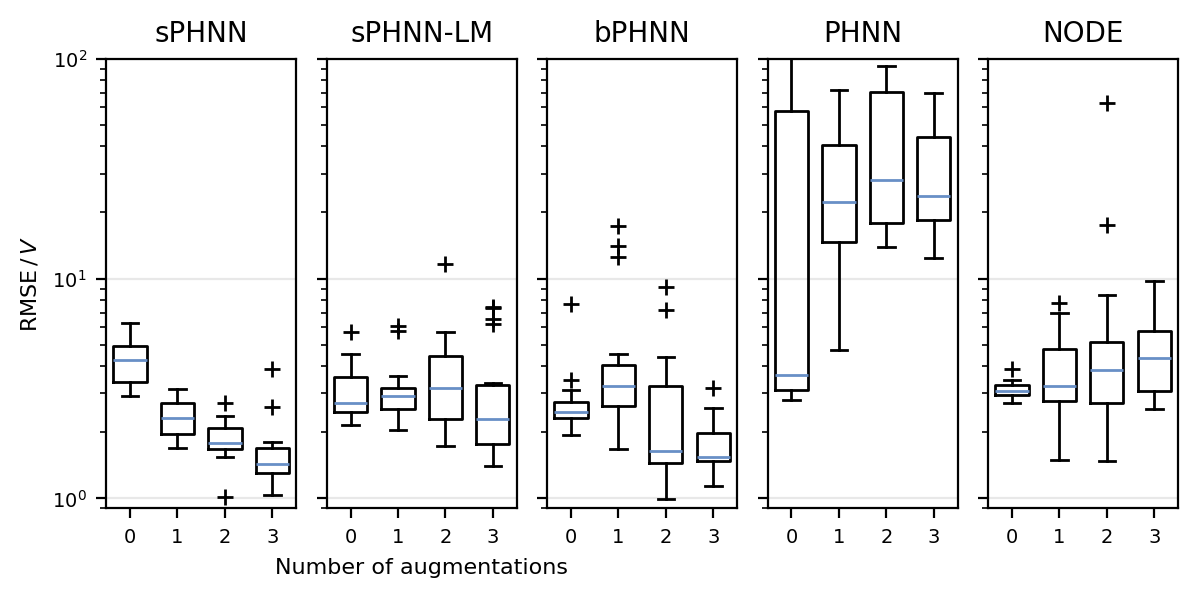

In [8]:

violinplot = False      # True -> Violinplot, False > Boxplot
colorful = False        # If true, then the median lines are drawn in the model color

use_types = ['sPHNN', 'sPHNN-LM', 'cPHNN', 'PHNN', 'NODE']

plot_rmse_data = {}
for model_type, model_results in results.items():
    if model_type not in use_types:
        continue
    plot_rmse_data[model_type] = {}
    for num_aug, aug_results in model_results.items():
        plot_rmse_data[model_type][num_aug] = [
            instance_result['rmse_test'] if model_type == "sPHNN-LM" else instance_result['test_rmse'] for instance_result in aug_results
        ]

n_results = len(plot_rmse_data)
fig, axes = plt.subplots(1, n_results, figsize=(1.2*n_results, 3), dpi=PLOT_DPI, sharey=True)
if n_results == 1:
    axes = [axes]
# fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

for n, (ax, (model_type, rmses)) in enumerate(zip(axes, plot_rmse_data.items())):

    
    if violinplot:
        vp = ax.violinplot(rmses.values(), rmses.keys(), 
                  showextrema=True, showmeans=False, showmedians=True)
        plt.setp(vp['cmedians'], color='red')

        ax.set_xticks(list(rmses.keys()))
    else:
        bp = ax.boxplot(rmses.values(), notch=False, sym='+', vert=True, widths=0.7)
        plt.setp(bp['medians'], color=model_style[model_type]['c'] if colorful else colors.theme_colors['lightblue'])

        ax.set_xticklabels(rmses.keys())

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

    ax.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=model_names[model_type], #f'{len(rmses[0])} {model_type}',
        xlabel='Number of augmentations' if n==1 else '',
        ylabel=R'$\text{RMSE}\,/\,V$' if n==0 else '',
        ylim=[0.9, 100],
        yscale='log',
    )

fig.tight_layout()
name_add_on = 'violinplot' if violinplot else 'boxplot'
plt.show()

#### Custom trajectory experiment

In [9]:
ts_eval = jnp.linspace(0, 5000, 1000)
ys_eval = np.full((ts_eval.size, 2), np.nan)
ys_eval[0,:] = 279.15
m1 = 50
m2 = 100

us_eval = np.full((ts_eval.size, 1), 279.15)
mask1 = np.logical_and(100<ts_eval, ts_eval<800)
us_eval[mask1] = 400
mask2 = ts_eval>=800
us_eval[mask2] = 310
us_eval = jnp.array(us_eval)

prediction_data, true_data = get_prediction_statistics(ts_eval, ys_eval, us_eval, results)

# of valid sPHNN predictions: 20
# of valid sPHNN predictions: 20
# of valid sPHNN predictions: 20
# of valid sPHNN predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid cPHNN predictions: 20
# of valid cPHNN predictions: 20
# of valid cPHNN predictions: 20
# of valid cPHNN predictions: 20
# of valid PHNN predictions: 20
# of valid PHNN predictions: 20
# of valid PHNN predictions: 20
# of valid PHNN predictions: 20
# of valid NODE predictions: 20
# of valid NODE predictions: 20
# of valid NODE predictions: 20
# of valid NODE predictions: 20


C:\Users\roth\AppData\Local\Temp\ipykernel_51760\1831255565.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


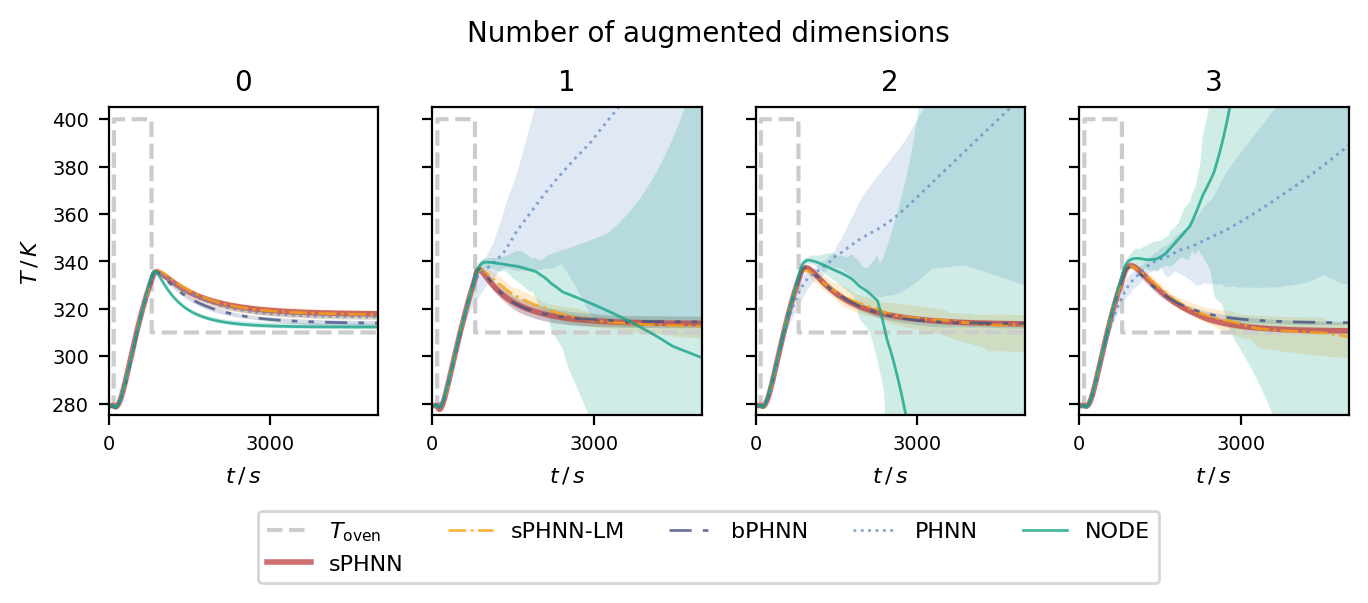

In [12]:
n_augs = max([len(x) for x in prediction_data.values()])

fig, axes = plt.subplots(1, n_augs, sharey=True, figsize=(2*n_augs, 2), dpi=PLOT_DPI)
axes = np.atleast_1d(axes)

for ax in axes.flatten():
    ax.plot(true_data['ts'], true_data['us'].squeeze(), '--', c=colors.theme_colors['grey'], label=R'$T_\text{oven}$')

use_line = 'interquartile_mean'
for model_type, model_plot_data in prediction_data.items():
    # if model_type in ['PHNN', 'NODE']:
    #     continue
    for col, (aug_dim, aug_plot_data) in enumerate(model_plot_data.items()):

        ax = axes[col]
        line, = ax.plot(true_data['ts'], aug_plot_data['ys'][use_line][0,:,0], 
                        **model_style[model_type], label=model_names[model_type])
        ax.fill_between(true_data['ts'], 
                        aug_plot_data['ys']['first_quartile'][0,:,0], 
                        aug_plot_data['ys']['third_quartile'][0,:,0], 
                        lw=0, alpha=0.2, zorder=1, color=line.get_color())
        ax.set(
            title=aug_dim,
            ylabel='$T\,/\,K$' if col==0 else '',
            ylim=[275,405],
            xlabel='$t\,/\,s$',
            xlim=[true_data['ts'].min(), true_data['ts'].max()],
            xticks=[0, 3000],
        )

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           bbox_transform=fig.transFigure, fancybox=True, shadow=False, ncol=5)
fig.suptitle('Number of augmented dimensions', y=1.1)
fig.tight_layout()
plt.show()

#### Plot predictions for a test trajectory

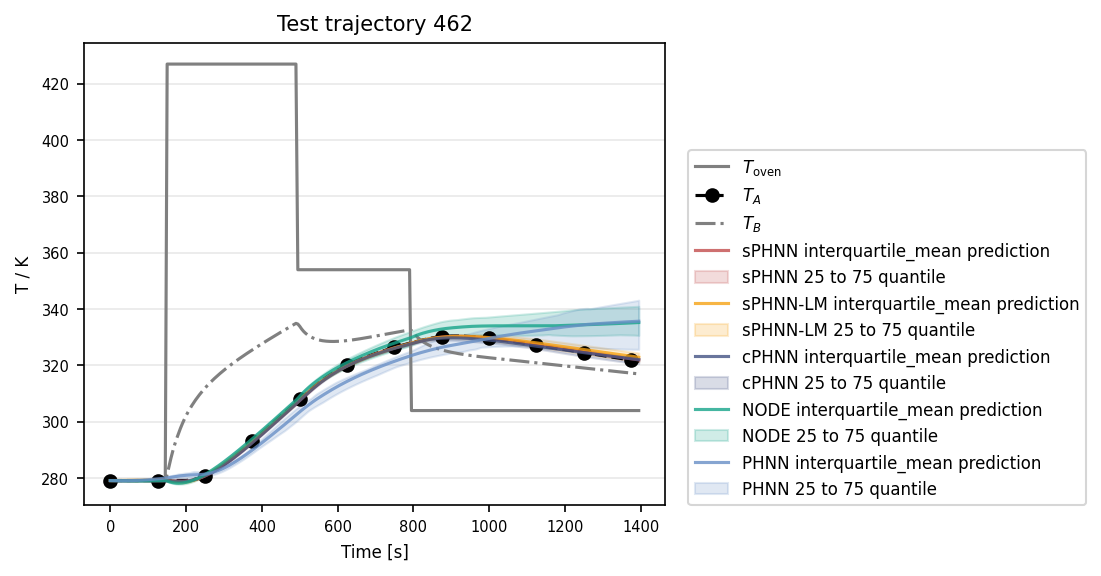

In [13]:
use_test_id = 9
use_aug_dim = 3
use_model_types = ['sPHNN', 'sPHNN-LM', 'cPHNN', 'NODE', 'PHNN']

ts_eval = test_data[0]
ys_eval = test_data[1][use_test_id]
us_eval = test_data[2][use_test_id]


plot_data = dict(ts = ts_eval, ys=ys_eval, us=us_eval)
for model_type in use_model_types:
    plot_data[model_type] = {}
    aug_results = results[model_type][use_aug_dim]
    ys_preds = np.empty((len(aug_results), ts_eval.shape[0], 2))
    for n, instance_result in enumerate(aug_results):
        model = instance_result['wrapped_model']
        ys_preds[n] = model(ts_eval, ys_eval[0], us_eval)

    plot_data[model_type][use_aug_dim] = evaluation.get_statistics(ys_preds)
use_line = 'interquartile_mean'


ts_plot = plot_data['ts']
ys_plot = plot_data['ys']
us_plot = plot_data['us']

fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)
ax.plot(ts_plot, us_plot.squeeze(), c='grey', label=R'$T_{\text{oven}}$')
ax.plot(ts_plot, ys_plot[:,0], c='black', ls='--', label='$T_A$', marker='o', markevery=25)
ax.plot(ts_plot, ys_plot[:,1], c='gray', ls='-.', label='$T_B$')

for model_type in use_model_types:
    metrics = plot_data[model_type][use_aug_dim]

    line, = ax.plot(ts_plot, metrics[use_line][:,0], 
                    '-', c=model_style[model_type]['c'], alpha=0.8, 
                    label=f'{model_type} {use_line} prediction')
    ax.fill_between(ts_plot, metrics['first_quartile'][:,0], metrics['third_quartile'][:,0], 
                    alpha=0.2, zorder=1, color=line.get_color(), 
                    label=f'{model_type} 25 to 75 quantile')
    
ax.set(
    axisbelow=True,
    title=f'Test trajectory {test_ids[use_test_id]}',
    xlabel='Time [s]',
    ylabel=R'T / K',
)

plt.legend(loc=(1.04, 0))
plt.show()